In [79]:
import pandas as pd

df = pd.read_csv('/content/100_Unique_QA_Dataset.csv')

df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


In [80]:
# tokenize
def tokenize(text):
  text = text.lower()
  text = text.replace('?','')
  text = text.replace("'","")
  return text.split()

In [81]:
tokenize('What is the capital of France?')

['what', 'is', 'the', 'capital', 'of', 'france']

In [82]:
# vocab
vocab = {'<UNK>':0}

In [83]:
def build_vocab(row):
  tokenized_question = tokenize(row['question'])
  tokenized_answer = tokenize(row['answer'])

  merged_tokens = tokenized_question + tokenized_answer

  for token in merged_tokens:

    if token not in vocab:
      vocab[token] = len(vocab)


In [84]:
df.apply(build_vocab, axis=1)

,0
0,None
1,None
2,None
3,None
4,None
...,...
85,None
86,None
87,None
88,None


In [85]:
len(vocab)

324

In [86]:
# convert words to numerical indices
def text_to_indices(text, vocab):

  indexed_text = []

  for token in tokenize(text):

    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<UNK>'])

  return indexed_text

In [87]:
text_to_indices("Who wrote 'To Kill a Mockingbird'?. wow", vocab)

[10, 11, 12, 13, 14, 0, 0]

In [88]:
import torch
from torch.utils.data import Dataset, DataLoader

In [89]:
class QADataset(Dataset):

  def __init__(self, df, vocab):
    self.df = df
    self.vocab = vocab

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):

    numerical_question = text_to_indices(self.df.iloc[index]['question'], self.vocab)
    numerical_answer = text_to_indices(self.df.iloc[index]['answer'], self.vocab)

    return torch.tensor(numerical_question), torch.tensor(numerical_answer)

In [90]:
dataset = QADataset(df, vocab)

In [91]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [92]:
for question, answer in dataloader:
  print(question, answer[0])

tensor([[ 42,   2,   3, 274, 211, 275]]) tensor([276])
tensor([[  1,   2,   3,   4,   5, 286]]) tensor([287])
tensor([[ 42, 174,   2,  62,  39, 175, 176,  12, 177, 178]]) tensor([179])
tensor([[ 1,  2,  3, 69,  5,  3, 70, 71]]) tensor([72])
tensor([[ 78,  79, 261, 151,  14, 262, 153]]) tensor([36])
tensor([[ 10, 140,   3, 141, 171,   5,   3,  70, 172]]) tensor([173])
tensor([[  1,   2,   3,  37, 133,   5,  26]]) tensor([134])
tensor([[  1,   2,   3, 234,   5, 235]]) tensor([131])
tensor([[ 42, 101,   2,   3,  17]]) tensor([102])
tensor([[  1,   2,   3,   4,   5, 113]]) tensor([114])
tensor([[10,  2,  3, 66,  5, 67]]) tensor([68])
tensor([[ 42, 117, 118,   3, 119,  94, 120]]) tensor([121])
tensor([[10, 75, 76]]) tensor([77])
tensor([[ 1,  2,  3, 69,  5, 53]]) tensor([260])
tensor([[ 42, 290, 291, 118, 292, 158, 293, 294]]) tensor([295])
tensor([[1, 2, 3, 4, 5, 8]]) tensor([9])
tensor([[  1,   2,   3, 122, 123,  19,   3,  45]]) tensor([124])
tensor([[  1,   2,   3,  92, 137,  19,   3,  4

In [93]:
import torch.nn as nn

In [94]:
class SimpleRNN(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim=50)
    self.rnn = nn.RNN(50, 64, batch_first=True)
    self.fc = nn.Linear(64, vocab_size)

  def forward(self, question):
    embedded_question = self.embedding(question)
    hidden, final = self.rnn(embedded_question)
    output = self.fc(final.squeeze(0))

    return output

In [101]:
learning_rate = 0.001
epochs = 50

In [102]:
model = SimpleRNN(len(vocab))

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [104]:
len(dataloader)

90

In [105]:
import time

In [106]:
# Lists to store loss and accuracy
losses = []
accuracies = []

# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    st = time.time()

    for question, answer in dataloader:
        optimizer.zero_grad()

        # Forward pass
        output = model(question)

        # Compute loss
        loss = criterion(output, answer[0])

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        predicted = torch.argmax(output, dim=1)  # Assuming classification task
        correct += (predicted == answer[0]).sum().item()
        total += answer[0].size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Accuracy percentage

    losses.append(avg_loss)
    accuracies.append(accuracy)

    if epoch % 5 == 0:
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, time: {(time.time()-st):.2f}s")

Epoch: 1, Loss: 5.8414, Accuracy: 0.00%, time: 0.27s
Epoch: 6, Loss: 2.4355, Accuracy: 83.33%, time: 0.26s
Epoch: 11, Loss: 0.7026, Accuracy: 96.67%, time: 0.27s
Epoch: 16, Loss: 0.2517, Accuracy: 98.89%, time: 0.27s
Epoch: 21, Loss: 0.1216, Accuracy: 100.00%, time: 0.25s
Epoch: 26, Loss: 0.0669, Accuracy: 100.00%, time: 0.37s
Epoch: 31, Loss: 0.0415, Accuracy: 100.00%, time: 0.28s
Epoch: 36, Loss: 0.0278, Accuracy: 100.00%, time: 0.36s
Epoch: 41, Loss: 0.0195, Accuracy: 100.00%, time: 0.31s
Epoch: 46, Loss: 0.0142, Accuracy: 100.00%, time: 0.28s


In [107]:
import matplotlib.pyplot as plt

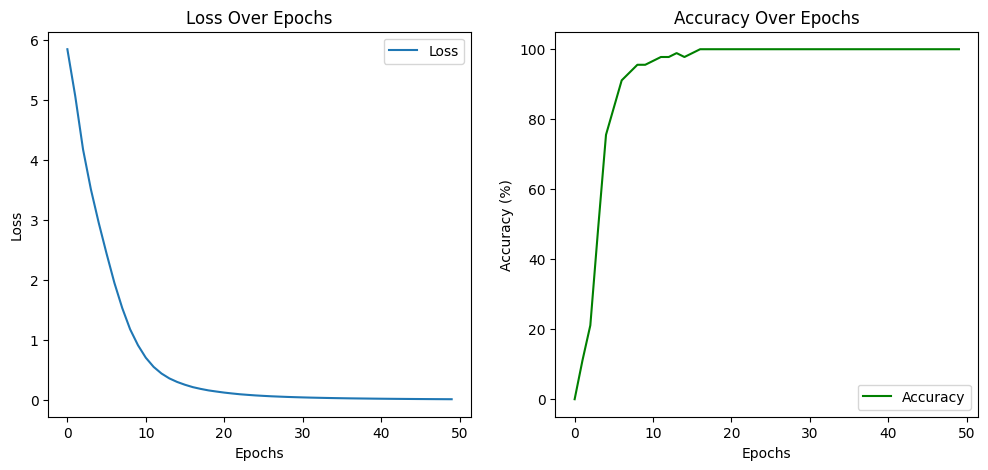

In [108]:
# Plot Loss and Accuracy Graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), accuracies, label="Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()

In [109]:
def predict(model, question, threshold=0.7):

  # convert question to numbers
  numerical_question = text_to_indices(question, vocab)

  # tensor
  question_tensor = torch.tensor(numerical_question).unsqueeze(0)

  # send to model
  output = model(question_tensor)

  # convert logits to probs
  probs = torch.nn.functional.softmax(output, dim=1)

  # find index of max prob
  value, index = torch.max(probs, dim=1)

  if value < threshold:
    print("I don't know")
  else:
    print(list(vocab.keys())[index])

In [110]:
predict(model, "What is the capital of France?")

paris


In [111]:
list(vocab.keys())[7]

'paris'

In [112]:
model_path = "trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to trained_model.pth
